# SARIMA Modeling

c:\Users\ttfee\OneDrive\Desktop\Stock Forecasting\utils.py:38: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index = df.index.to_period('D')


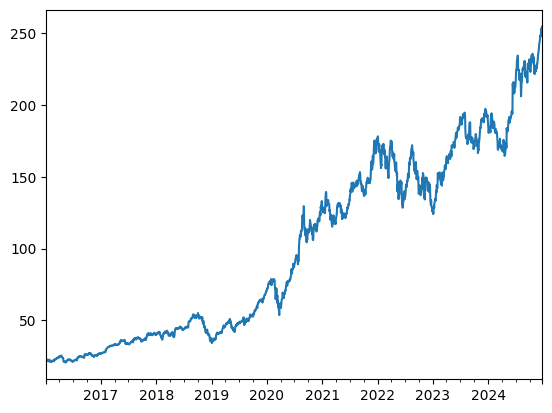

,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WST,WYNN,WY,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
count,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,...,2259.000000,2259.000000,2259.000000,2259.000000,2259.00000,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000
mean,101.332817,95.049566,81.028187,43.594086,216.661477,346.265031,122.418307,49.472786,159.979562,181.920723,...,218.070229,101.709694,26.581242,50.597031,68.52217,82.200926,96.769838,120.516467,249.009100,125.652388
std,64.768562,43.398437,29.220469,22.271707,87.598321,165.703447,51.380638,17.542686,61.732846,73.219702,...,122.867485,26.726625,4.960217,11.972562,24.58380,28.147597,25.224751,16.235936,138.801826,53.074294
min,20.710000,36.000000,30.970000,20.600000,81.400000,73.995226,40.730000,23.660000,63.880000,42.788353,...,52.910000,42.840000,11.460000,26.960000,24.84000,28.970000,51.480000,76.120000,46.784023,36.650000
25%,40.690000,61.495000,53.500000,28.295000,140.615000,219.865889,78.340000,34.985000,102.215000,127.207346,...,96.475000,83.645000,22.720000,38.465000,54.34000,62.210000,74.050000,109.355000,139.555360,78.590000
50%,88.530000,79.160000,86.900000,35.130000,202.380000,340.826691,108.370000,41.160000,149.060000,190.400472,...,217.660000,97.360000,26.790000,54.180000,59.10000,76.740000,96.610000,117.920000,245.364041,135.900000
75%,156.930000,135.260000,106.200000,45.630000,298.930000,487.446443,162.270000,61.195000,214.385000,238.650343,...,329.355000,117.640000,30.430000,60.375000,91.10500,104.020000,120.195000,128.415000,317.513662,170.395000
max,254.713849,204.178125,133.410000,108.850000,399.780000,690.082460,240.030000,91.770000,306.470000,341.558209,...,468.040000,185.440000,38.310000,72.932332,124.60000,144.330000,140.480000,173.760000,611.625112,240.160000


In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as u

vwap = u.get_stock_data(type='vwap')
vwap['AAPL'].plot(x='Date', y='AAPL')
plt.show()
vwap.describe()

<Axes: >

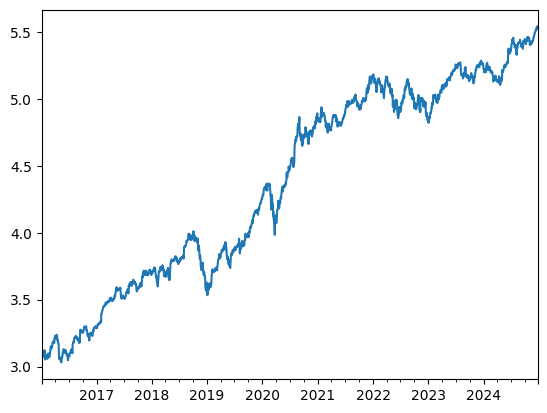

In [2]:
log_vwap = vwap.apply(lambda x: np.log(x+1e-6))
log_vwap['AAPL'].plot(x='Date', y='AAPL')

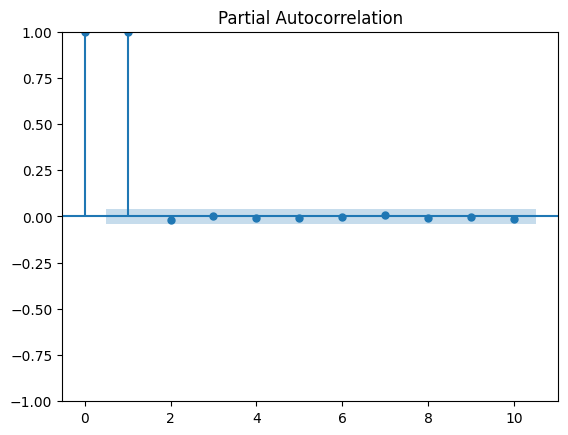

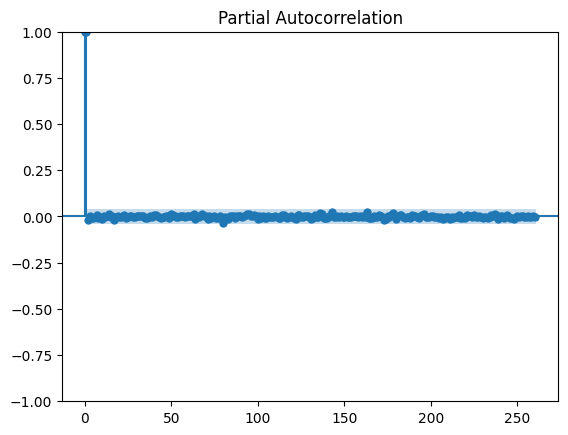

In [3]:
sm.graphics.tsa.plot_pacf(log_vwap['AAPL'], lags=10)
plt.show()
sm.graphics.tsa.plot_pacf(log_vwap['AAPL'], lags=260)
plt.show()

<Axes: >

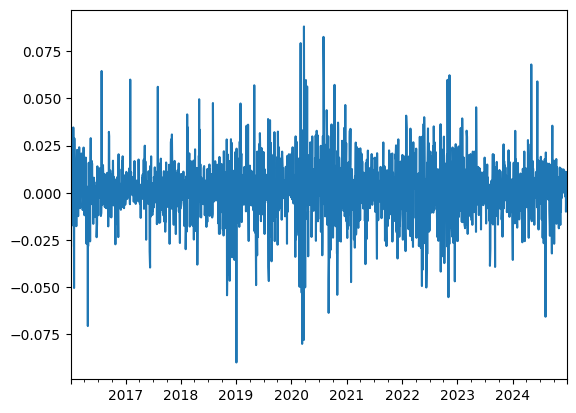

In [4]:
dvwap = log_vwap.diff()
dvwap.dropna(how='any', inplace=True)
dvwap['AAPL'].plot(x='Date', y='AAPL')

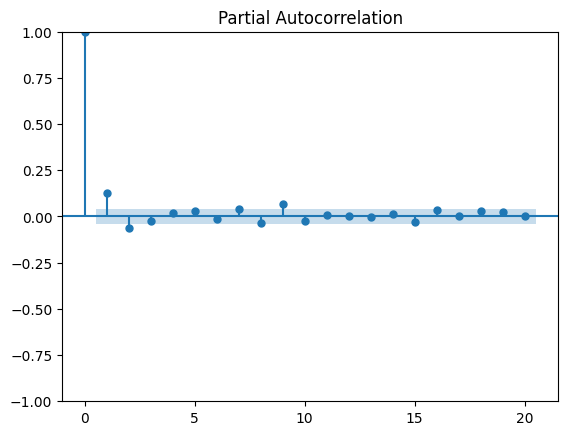

In [5]:
sm.graphics.tsa.plot_pacf(dvwap['AAPL'], lags=20)
plt.show()

In [12]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

u.check_stationarity(dvwap, pvalue=0.000001)

100%|██████████| 469/469 [00:40<00:00, 11.71it/s]

All columns are stationary (threshold of p = 5e-06)


100%|██████████| 469/469 [00:04<00:00, 100.55it/s]


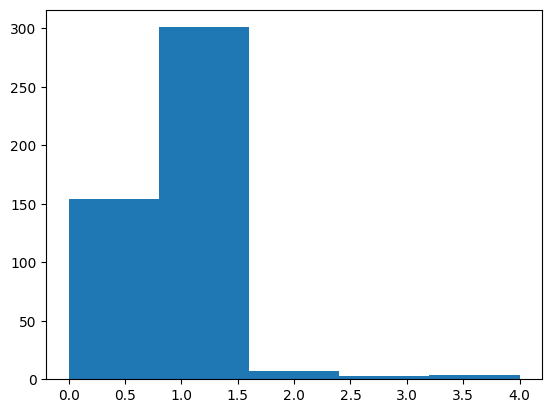

In [13]:
from tqdm import tqdm

best_lags = []
good_stocks = []
for col in tqdm(dvwap.columns):
    champ = -1
    best = np.inf

    for lags in range(5):
        model = AutoReg(dvwap[col], lags=lags)
        model_fit = model.fit()

        if model_fit.bic < best:
            champ = lags
            best = model_fit.bic

    if champ > 0:
        good_stocks.append(col)
    best_lags.append(champ)


plt.hist(best_lags, bins=5)

plt.show()

In [14]:
model = VAR(dvwap)
lag_order = model.select_order()
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -4258.     -4257.*      0.000*     -4258.*
1      -4223.      -3664.       0.000      -4019.
2      -4219.      -3102.       0.000      -3812.
3     -4317.*      -2641.       0.000      -3705.
-------------------------------------------------


BIC, the most robust penalty for stock forecasting, is lowest for lag 0. This means trying to use the current daily stock returns, in aggregate, to predict their values the next day is **not statistically justified**.

In [9]:
model = VAR(dvwap[good_stocks])
lag_order = model.select_order(3)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -2823.*     -2823.*      0.000*     -2823.*
1      -2806.      -2553.       0.000      -2714.
2      -2790.      -2286.       0.000      -2606.
3      -2788.      -2032.       0.000      -2512.
-------------------------------------------------


Even excluding the individual stocks whose univariate BIC is best at 0 (the stocks with daily returns best modeled by white noise), the mutlivariate case still results in a best BIC with lag 0. This makes sense. Fitting a VAR model with 315 stocks, even with only a lag of 1, requires selecting around $315^2 \approx 100,000$ parameters. This is way too many for the small amount of stock data we have, not to mention the fact that stock returns have very high variance.

In [17]:
print(f'Number of \'good stocks\': {len(good_stocks)}')

Number of 'good stocks': 315


# By industry

In [18]:
df_sp = pd.read_csv('./data/s&p500.csv')
sectors = list(df_sp['GICS Sector'].value_counts().index)

by_industry = {}
for sector in sectors:
    stocks = list(df_sp.loc[df_sp['GICS Sector'] == sector]['Symbol'])
    stks = [stk for stk in stocks if stk in dvwap.columns]
    by_industry[sector] = stks
    print(f"{sector:25}", stks)

Industrials               ['MMM', 'AOS', 'ALLE', 'AME', 'ADP', 'AXON', 'BA', 'BR', 'BLDR', 'CHRW', 'CAT', 'CTAS', 'CPRT', 'CSX', 'CMI', 'DE', 'DAL', 'DOV', 'ETN', 'EMR', 'EFX', 'EXPD', 'FAST', 'FDX', 'GE', 'GNRC', 'GD', 'HON', 'HUBB', 'HII', 'IEX', 'ITW', 'IR', 'JBHT', 'J', 'JCI', 'LHX', 'LDOS', 'LMT', 'MAS', 'NDSN', 'NSC', 'NOC', 'ODFL', 'PCAR', 'PH', 'PAYX', 'PAYC', 'PNR', 'PWR', 'RTX', 'RSG', 'ROK', 'ROL', 'SNA', 'LUV', 'SWK', 'TXT', 'TDG', 'UNP', 'UAL', 'UPS', 'URI', 'VRSK', 'GWW', 'WAB', 'WM', 'XYL']
Financials                ['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'ACGL', 'AJG', 'AIZ', 'BAC', 'BRK.B', 'BLK', 'BX', 'BK', 'BRO', 'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG', 'CME', 'CPAY', 'DFS', 'ERIE', 'EG', 'FDS', 'FIS', 'FITB', 'FI', 'BEN', 'GPN', 'GL', 'GS', 'HIG', 'HBAN', 'ICE', 'IVZ', 'JKHY', 'JPM', 'KEY', 'KKR', 'L', 'MTB', 'MKTX', 'MMC', 'MA', 'MET', 'MCO', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PYPL', 'PNC', 'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'STT', 'SYF', 'TROW', 'TR

In [9]:
for sector, stocks in by_industry.items():
    print(f"{sector:25}", stocks)
    model = VAR(dvwap[stocks])
    lag_order = model.select_order(3)
    print(lag_order.summary())

Industrials               ['MMM', 'AOS', 'ALLE', 'AME', 'ADP', 'AXON', 'BA', 'BR', 'BLDR', 'CHRW', 'CAT', 'CTAS', 'CPRT', 'CSX', 'CMI', 'DE', 'DAL', 'DOV', 'ETN', 'EMR', 'EFX', 'EXPD', 'FAST', 'FDX', 'GE', 'GNRC', 'GD', 'HON', 'HUBB', 'HII', 'IEX', 'ITW', 'IR', 'JBHT', 'J', 'JCI', 'LHX', 'LDOS', 'LMT', 'MAS', 'NDSN', 'NSC', 'NOC', 'ODFL', 'PCAR', 'PH', 'PAYX', 'PAYC', 'PNR', 'PWR', 'RTX', 'RSG', 'ROK', 'ROL', 'SNA', 'LUV', 'SWK', 'TXT', 'TDG', 'UNP', 'UAL', 'UPS', 'URI', 'VRSK', 'GWW', 'WAB', 'WM', 'XYL']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -603.6     -603.4*  7.162e-263     -603.5*
1     -603.7*      -591.8 6.691e-263*      -599.3
2      -602.9      -579.2  1.539e-262      -594.2
3      -601.9      -566.5  4.290e-262      -588.9
-------------------------------------------------
Financials                ['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'ACGL', 'AJG', 'AIZ'

Within each industry, BIC remains 0.

In [33]:
for sector, stocks in by_industry.items():
    stks = [stk for stk in stocks if stk in good_stocks]
    print(f"{sector:25}", stks)
    model = VAR(dvwap[stks])
    lag_order = model.select_order(3)
    print(lag_order.summary())

Industrials               ['MMM', 'AOS', 'ALLE', 'AXON', 'BA', 'BLDR', 'CAT', 'CPRT', 'DE', 'DAL', 'EFX', 'EXPD', 'FAST', 'FDX', 'GNRC', 'GD', 'HON', 'HII', 'ITW', 'JBHT', 'J', 'LHX', 'LDOS', 'LMT', 'MAS', 'NOC', 'ODFL', 'PCAR', 'PH', 'PAYC', 'PNR', 'PWR', 'ROL', 'SNA', 'LUV', 'SWK', 'TXT', 'TDG', 'UAL', 'UPS', 'URI', 'GWW', 'WAB']
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -377.6     -377.5*  1.040e-164     -377.5*
1     -377.9*      -373.1 7.757e-165*      -376.1
2      -377.6      -368.1  1.056e-164      -374.1
3      -377.1      -363.0  1.618e-164      -372.0
-------------------------------------------------
Financials                ['AFL', 'AXP', 'AIG', 'AON', 'ACGL', 'BAC', 'BX', 'COF', 'CBOE', 'SCHW', 'CB', 'C', 'CPAY', 'DFS', 'FIS', 'FITB', 'BEN', 'GPN', 'GL', 'GS', 'HBAN', 'ICE', 'IVZ', 'KKR', 'MKTX', 'MA', 'MCO', 'NDAQ', 'PYPL', 'PFG', 'PRU', 'RF', 'SYF', 'TROW',

Even when clustering the stocks with significant univariate autocorrelation according to industry, no multivariate cluster retains this significance.

# Between Industries

In [34]:
vwap = pd.read_csv('vwap.csv')
vwap.index = list(vwap['Unnamed: 0'])
vwap.drop(['Unnamed: 0'], axis=1, inplace=True)
vwap.index = pd.to_datetime(vwap.index)

vol = pd.read_csv('volume.csv')
vol.index = list(vol['Unnamed: 0'])
vol.drop(['Unnamed: 0'], axis=1, inplace=True)
vol.index = pd.to_datetime(vol.index)

sect = pd.DataFrame()
for sector, stocks in by_industry.items():
    sect[sector] = (vwap[stocks] * vol[stocks]
                            ).sum(axis=1) / vol[stocks].sum(axis=1)

In [35]:
dsect = sect.apply(lambda x: np.log(1e-6 + x)).diff()
dsect.dropna(inplace=True)

model = VAR(dsect)
lag_order = model.select_order(10)
print(lag_order.summary())

c:\Users\ttfee\OneDrive\Desktop\Stock Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -56.94      -56.92   1.859e-25      -56.93
1       -58.06      -57.72   6.098e-26      -57.94
2       -58.58     -57.93*   3.632e-26      -58.34
3       -58.81      -57.86   2.886e-26      -58.46
4       -58.94      -57.68   2.540e-26     -58.48*
5       -58.99      -57.42   2.414e-26      -58.41
6      -59.02*      -57.15  2.333e-26*      -58.34
7       -59.02      -56.83   2.345e-26      -58.22
8       -59.01      -56.52   2.354e-26      -58.10
9       -58.99      -56.19   2.409e-26      -57.97
10      -58.96      -55.86   2.472e-26      -57.83
--------------------------------------------------


Finally! The BIC is minimized for a lag of 2. There's some day-level predictability between VWAP stock prices between industries. In fact, we do not get a BIC worse than lag 0 until we reach lag 7.

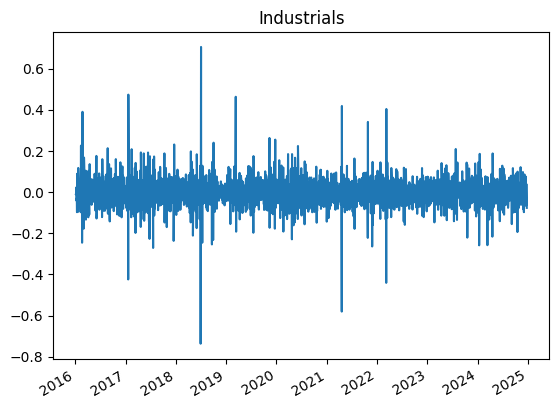

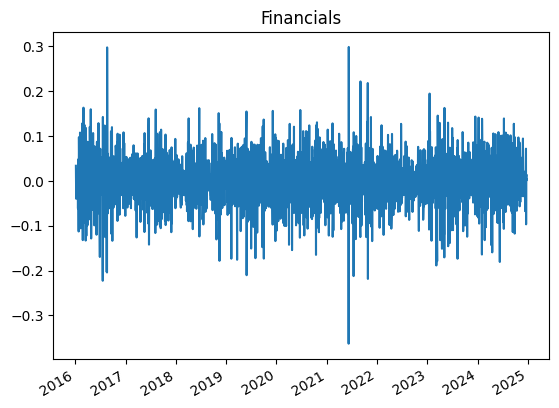

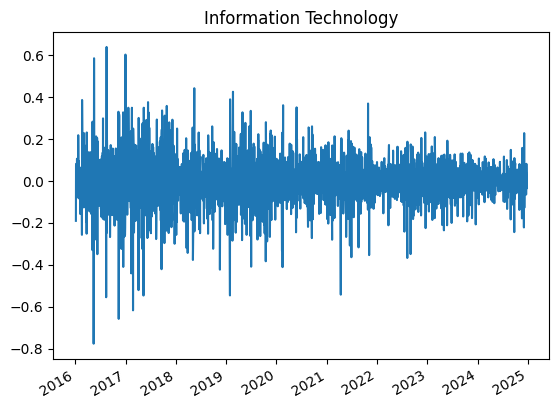

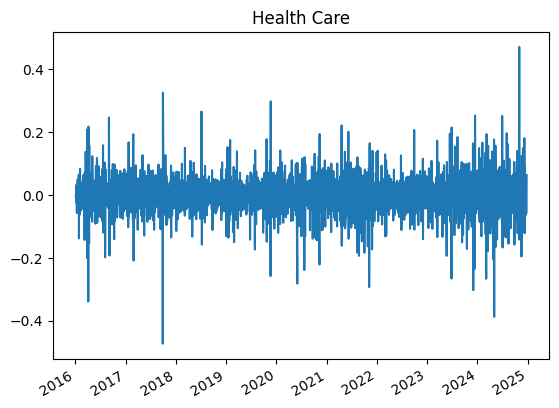

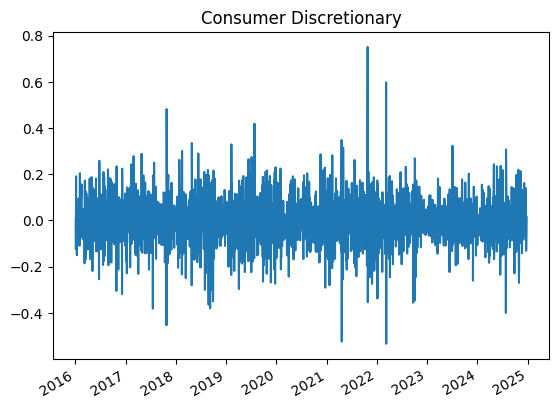

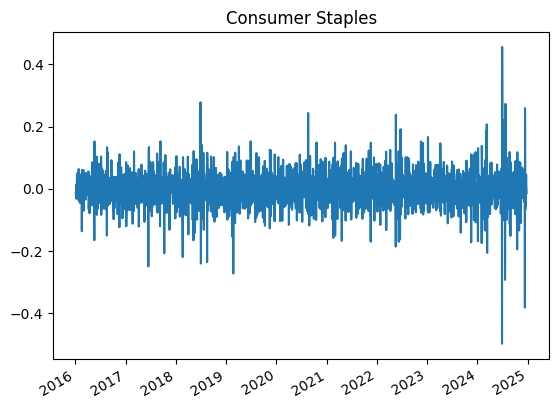

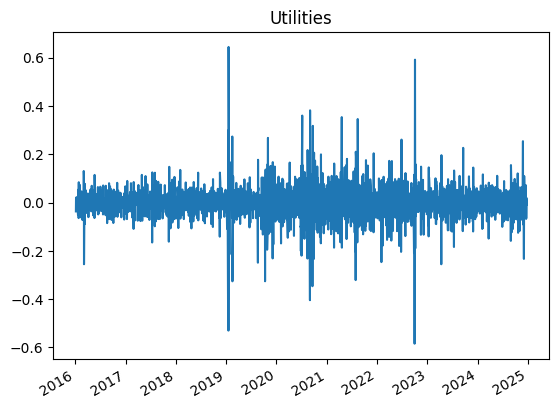

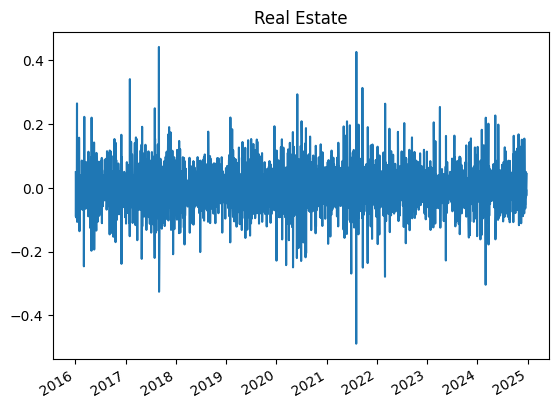

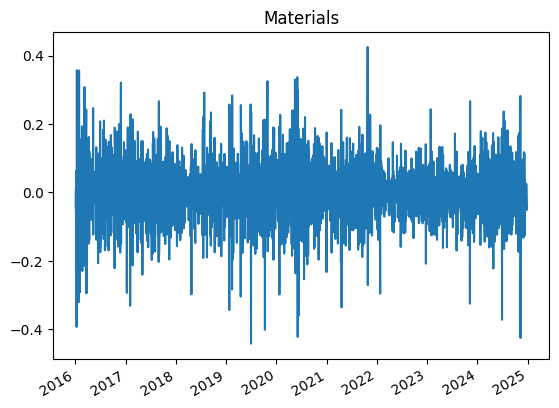

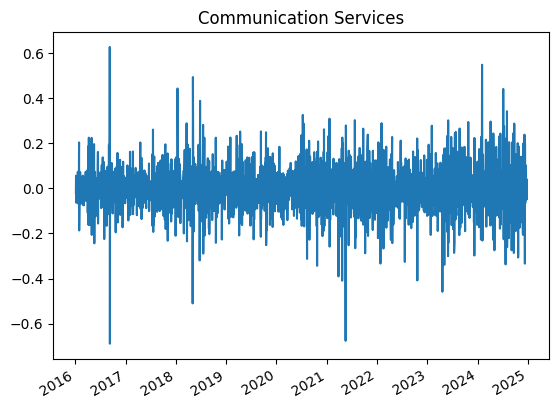

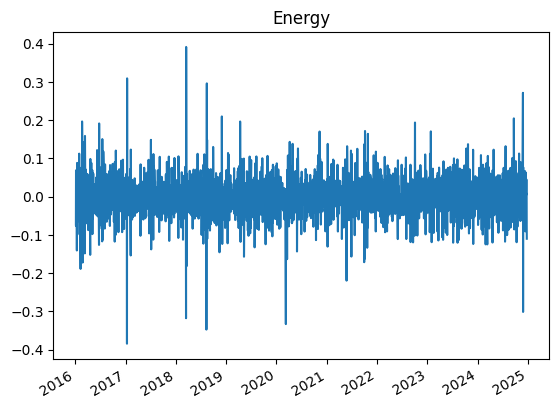

In [12]:
for sec in dsect.columns:
    dsect[sec].plot()
    plt.title(sec)
    plt.show()